# Inappropriate Image Detection using Tensorflow CNN

Tujuan dari pembuatan model deteksi gambar kurang senonoh adalah sebagai solusi dalam mencegah user mengupload gambar kurang senonoh pada laman web BISA.AI dan CENTRAL.AI

Algoritma yang digunakan adalah CNN dalam membantu model mengekstrak setiap fitur pada masing-masing gambar, dengan menggunakan single label diharapkan hasil akurasi setiap gambar yang dilatih dan diuji dapat memenuhi kriteria yang diinginkan.

Dataset diperoleh melalui repository github yang dibuat oleh [EBazarov](https://github.com/EBazarov/nsfw_data_source_urls) yang merupakan pengembangan dari versi sebelumnya. Dalam repository, termuat link yang user telah download dan dibersihkan. Dalam testing model, user telah menyiapkan 7 label klasifikasi gambar yaitu: ass, breast, nudity, sex_toys, female, dan male. Satu kategori lainnya adalah neutral, dimana termuat data neutral image yang diperoleh melalui Large Selfie Dataset dari [UCF Central For Research In Computer Vision](https://www.crcv.ucf.edu/data/Selfie/).

Adapun flowchart pada project ini dimulai dari proses input dataset, dilakukan pre-proses data (cleaning, compress, splitting). Kemudian data akan dilatih agar memperoleh output seperti yang tertera pada flowchart project ini.

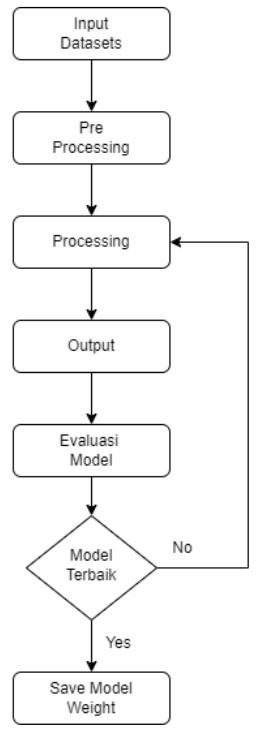

## Load Data & Eksplorasi Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import SGD, Adam
from pathlib import Path
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization
from tensorflow.keras import initializers, regularizers
from pathlib import Path
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, History, LearningRateScheduler
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.image as mpimg

In [8]:
# Lokasi dataset yang digunakan
main_dir = '/content/drive/MyDrive/dataset/'
train_dir = main_dir + 'train/'
test_dir = main_dir + 'test/'

# Cek jumlah data pada setiap kategori
train_ass = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/ass')]))
test_ass = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/ass')]))
train_breast = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/breast')]))
test_breast = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/breast')]))
train_female = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/female')]))
test_female = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/female')]))
train_male = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/male')]))
test_male = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/male')]))
train_neutral = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/neutral')]))
test_neutral = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/neutral')]))
train_nudity = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/nudity')]))
test_nudity = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/nudity')]))
train_toys = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/train/toys')]))
test_toys = (len([iq for iq in os.scandir('/content/drive/MyDrive/dataset/test/toys')]))

In [9]:
# List
train_data = [train_ass, train_breast, train_female, train_male, train_neutral, train_nudity, train_toys]
test_data = [test_ass, test_breast, test_female, test_male, test_neutral, test_nudity, test_toys]

In [10]:
# Mengecek total data yang tersedia
print("Total jumlah data untuk dilatih adalah : ", train_data[0], "+", train_data[1], "+", train_data[2], "+", train_data[3], "+", train_data[4], "+", train_data[5], "+", train_data[6],"=", sum(train_data))
print("Total jumlah data untuk testing adalah : ", test_data[0], "+", test_data[1], "+", test_data[2], "+", test_data[3], "+", test_data[4], "+", test_data[5], "+", test_data[6],"=", sum(test_data))

Total jumlah data untuk dilatih adalah :  150 + 150 + 150 + 150 + 150 + 150 + 150 = 1050
Total jumlah data untuk testing adalah :  50 + 50 + 50 + 50 + 50 + 50 + 50 = 350


Expected result:

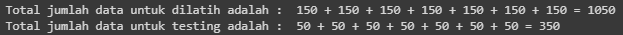

In [12]:
train_path =r"/content/drive/MyDrive/dataset/train/"
test_path = r"/content/drive/MyDrive/dataset/test/"

Terdapat 1050 Gambar untuk dilatih dan 350 gambar untuk testing

Sample ass image:


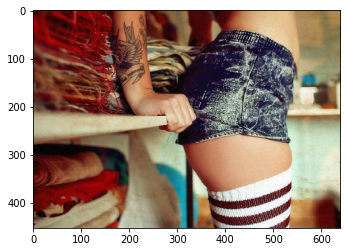


Sample neutral image:


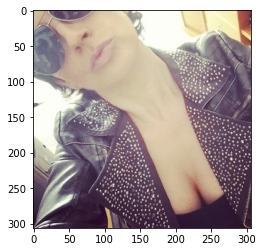

In [ ]:
train_ass_dir = '/content/drive/MyDrive/dataset/train/ass'
train_neutral_dir = '/content/drive/MyDrive/dataset/train/neutral'
train_nudity_dir = '/content/drive/MyDrive/dataset/train/nudity'

print("Sample ass image:")
plt.imshow(load_img(f"{os.path.join(train_ass_dir, os.listdir(train_ass_dir)[0])}"))
plt.show()

print("\nSample neutral image:")
plt.imshow(load_img(f"{os.path.join(train_neutral_dir, os.listdir(train_neutral_dir)[0])}"))
plt.show()

Menggunakan library matplotlib untuk mengecek shape dari gambar

In [ ]:
# Load the first example of a horse
sampel_gambar  = load_img(f"{os.path.join(train_nudity_dir, os.listdir(train_nudity_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sampel_gambar)

print(f"Berikut adalah shape dari sampel gambar: {sample_array.shape}")

Berikut adalah shape dari sampel gambar: (480, 312, 3)


Dapat dilihat bahwa shape gambar masih belum identik, maka dari itu saat preproses data diperlukan scaling pada gambar untuk memperoleh shape yang serupa pada setiap data.

## Preproses Data

Dibutuhkan model yang cepat dan memiliki akurasi tinggi serta parameter yang tidak terlalu banyak maka dari itu user memilih menggunakan MobileNet. Dengan kata lain dilakukan transfer learning dan memilih berat model yang telah dilatih untuk ImageNet.

In [ ]:
# Menggunakan input_size 224 agar dapat menggunakan ImageNet
size = 224
# epochs = 100
# steps = 500
epochs = 100
steps = 50

In [ ]:
# Menggunakan Augmentasi pada data gambar untuk memperbanyak variasi data yang dilatih dan menghindari overfitting
train_data_generation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=20,
    horizontal_flip=True
)
validation_data_generation = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_data_generation.flow_from_directory(
        train_path,
        target_size=(size, size),
        class_mode='categorical',
        batch_size = 64
    )

validation_generator = validation_data_generation.flow_from_directory(
    test_path,
    target_size=(size, size),
    class_mode='categorical',
    batch_size = 64
)

Found 1050 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


Expected output:

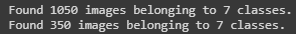

## Prosesing Data

In [ ]:
# Menggunakan pretrained model dari MobileNetV2
conv_m = MobileNetV2(weights='imagenet', include_top=False, input_shape=(size, size, 3))
conv_m.trainable = False
conv_m.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [ ]:
model = Sequential()
model.add(conv_m)
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                        

In [ ]:
from time import time
filepath = "bestweight.h5"
checkpoint = ModelCheckpoint("weights{epoch:05d}.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=5, verbose=1, cooldown=0, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reduce]

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr = 0.1, momentum = 0.9),
    metrics=['accuracy']
)

In [ ]:
# model = load_model("nsfwnsfw_mobilenet2_30.h5")

In [ ]:
start = datetime.now()
history = model.fit_generator(
    train_generator,
    callbacks=callbacks,
    epochs=100,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    initial_epoch = 30
)

Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.7750
Epoch 31: accuracy improved from -inf to 0.77500, saving model to weights00031.h5
10/10 [==============================] - 33s 3s/step - loss: 0.6882 - accuracy: 0.7750 - lr: 0.1000
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7953
Epoch 32: accuracy improved from 0.77500 to 0.79531, saving model to weights00032.h5
10/10 [==============================] - 28s 3s/step - loss: 0.5662 - accuracy: 0.7953 - lr: 0.1000
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8188
Epoch 33: accuracy improved from 0.79531 to 0.81875, saving model to weights00033.h5
10/10 [==============================] - 27s 3s/step - loss: 0.4980 - accuracy: 0.8188 - lr: 0.1000
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.8234
Epoch 34: accuracy improved from 0.81875 to 0.82344, saving mode

Didapat akurasi sebesar 87.7% melalui hasil training model, dilanjutkan ke proses evaluasi model.

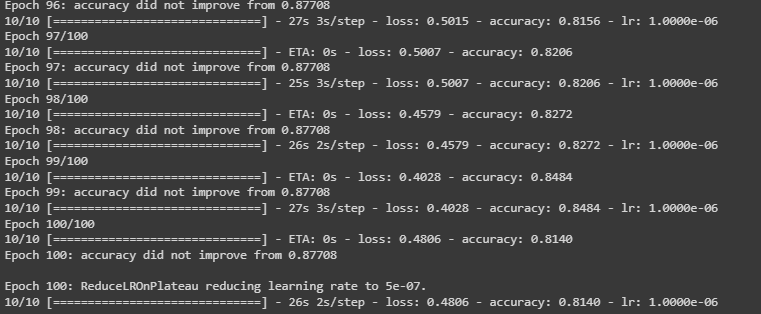

## Evaluasi Kinerja Model

In [ ]:
print("time taken : ", datetime.now() - start)

time taken :  0:40:42.919801


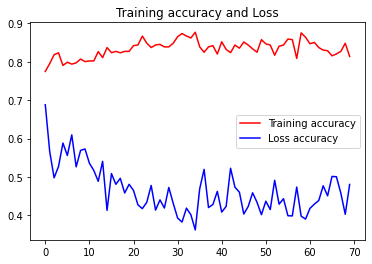

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training accuracy untuk setiap epoch

acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Loss accuracy')
plt.title('Training accuracy and Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Dapat dilihat bahwa akurasi semakin membesar sedangkan loss semakin mengecil saat running epoch ke 60-an, dan didapat pada running epoch ke 65 akurasi menyentuh 87,7%.

## Load dan Tes Performa Model

In [3]:
from tensorflow.keras.models import Sequential, Model, load_model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
model = load_model("/content/drive/MyDrive/dataset/inappropriate_87acc.h5")

In [13]:
test_file1 = test_path+"/ass/3k5OU7E.jpg"

ass [[0.87 0.13 0.   0.   0.   0.   0.  ]]
With 0.870897114276886 probability


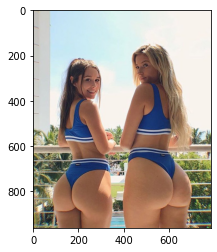

In [14]:
# Recall gambar pertama

from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    img=mpimg.imread(filename)
    plt.imshow(img)
    return np_image

image = load(test_file1)
ans = model.predict(image)
maping = {0 : "ass", 1 : "breast", 2 : "female", 3 : "male", 4 : "neutral", 5 : "nudity", 6 : "toys"}
new_ans = np.argmax(ans[0])

print(maping[new_ans], np.round(ans,2))
print("With {} probability".format(ans[0][new_ans]))

In [15]:
test_file2 = test_path+"/toys/222_023cfe41.jpg"

toys [[0. 0. 0. 0. 0. 0. 1.]]
With 0.9999562501907349 probability


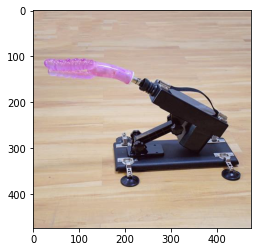

In [16]:
# Recall gambar kedua

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    img=mpimg.imread(filename)
    plt.imshow(img)
    return np_image

image = load(test_file2)
ans = model.predict(image)
maping = {0 : "ass", 1 : "breast", 2 : "female", 3 : "male", 4 : "neutral", 5 : "nudity", 6 : "toys"}
new_ans = np.argmax(ans[0])

print(maping[new_ans], np.round(ans,2))
print("With {} probability".format(ans[0][new_ans]))

In [29]:
test_file3 = test_path+"/breast/LC7Jvvm.jpg"

breast [[0.19 0.79 0.   0.   0.   0.03 0.  ]]
With 0.7864100933074951 probability


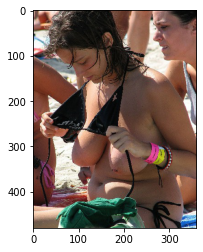

In [30]:
# Recall gambar kedua

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    img=mpimg.imread(filename)
    plt.imshow(img)
    return np_image

image = load(test_file3)
ans = model.predict(image)
maping = {0 : "ass", 1 : "breast", 2 : "female", 3 : "male", 4 : "neutral", 5 : "nudity", 6 : "toys"}
new_ans = np.argmax(ans[0])

print(maping[new_ans], np.round(ans,2))
print("With {} probability".format(ans[0][new_ans]))

In [37]:
test_file4 = test_path+"/neutral/063_2171ad68.jpg"

neutral [[0.01 0.   0.   0.   0.98 0.   0.  ]]
With 0.9814961552619934 probability


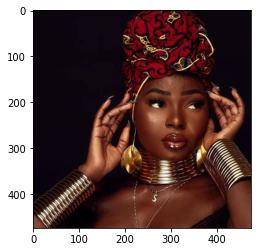

In [38]:
# Recall gambar kedua

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    img=mpimg.imread(filename)
    plt.imshow(img)
    return np_image

image = load(test_file4)
ans = model.predict(image)
maping = {0 : "ass", 1 : "breast", 2 : "female", 3 : "male", 4 : "neutral", 5 : "nudity", 6 : "toys"}
new_ans = np.argmax(ans[0])

print(maping[new_ans], np.round(ans,2))
print("With {} probability".format(ans[0][new_ans]))